<a href="https://colab.research.google.com/github/enlupi/SNN-MUC/blob/main/Scripts/DTFastSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SNN Implementation


In [1]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import snntorch.functional as SF

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Create Datasets

In [3]:
num_events = 100000
num_events_test = 6000

events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=0.4, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=0.4, bkg_frac=0.5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1037.47it/s]


In [4]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
muon_array = convert_to(muon_list, size=max_n, target_dtype=np.float32,
                        features=feature_list)
test_array = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32,
                        features=feature_list)

Generate target: NLAYERSxNWIRES (4x4 by defualt) matrices with 1 if a true hit from a muon has been registered in the time

In [5]:
def gen_target(muon_list):
    target = np.ones(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES), dtype=np.int16)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 0

    return torch.tensor(target, dtype=torch.long)

In [6]:
target = gen_target(muon_list)
target_test = gen_target(muon_list_test)

100000it [00:00, 564088.69it/s]
6000it [00:00, 218214.66it/s]


### Custom Dataset and Dataloader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    tensor = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = tensor.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

In [8]:
train_dataset = CustomDataset(muon_array, target, transform=transform)
test_dataset = CustomDataset(test_array, target_test, transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

### Create Spiketrain

In [9]:
'''
def custom_spikegen(data, num_step=40):
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
                
    return spike_data  
'''

In [10]:
def custom_spikegen(data_it, num_step=40):
    
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data_it.dtype)
    
    for n_batch, evt in enumerate(data_it):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
            
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)
            
            layer = int(hit[0])
            wire = int(hit[1])
            
            spike_data[time, n_batch, layer-1, wire-1] = 1

    return spike_data  

## Network Definition

In [11]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2*num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8
alpha = 0.5

In [12]:
class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [13]:
class Net2order(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta,alpha=alpha,
                                   spike_grad=spike_grad,
                                   threshold=0.9)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta,alpha=alpha,
                                    spike_grad=spike_grad,
                                    threshold=0.9,reset_mechanism = 'zero')
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [14]:
'''Work in progress'''

class Net2order2layers(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta,alpha=alpha,
                                   spike_grad=spike_grad,
                                   threshold=0.9)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta,alpha=alpha,
                                    spike_grad=spike_grad,
                                    threshold=0.9,reset_mechanism = 'zero')
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [15]:
net = Net(num_inputs, num_hidden, num_outputs, num_steps).to(device)
#net = Net2order(num_inputs, num_hidden, num_outputs, num_steps).to(device)

## Training

### Custom Loss Function

In [16]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                              targets[:, i])
        return loss

In [17]:
def print_accuracy(net,dataLoader):
    with torch.no_grad():
        net.eval()
        
        correct = 0
        total = 0
        for data,trg in dataLoader:
            
            data = data.to(device)
            trg = trg.to(device)
            
            # create spike train
            spike_in = custom_spikegen(data, num_steps)
            spike_in = spike_in.to(device)
            
            
            # forward pass
            spk, _ = net(spike_in.view(num_steps, batch_size, -1))
    
    
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data.size(0)
            total += batch_len
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == trg[i]).all())
         
            
    print(f"Total correctly classified events: {correct}/{total}")
    print(f"Accuracy: {100 * correct /total :.2f}%")

### Train Loop

In [18]:
num_epochs = 5
loss_hist = []
iter_counter = 0

#loss = nn.MSELoss()
loss_fn = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# Outer training loop
for epoch in range(num_epochs):
    batch_counter = 0
    # Minibatch training loop
    for data_it, targets_it in train_loader:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # create spike train
        spike_in = custom_spikegen(data_it, num_steps)
        spike_in = spike_in.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets_it.view(batch_size, -1))
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
        
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 8.471258163452148 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 5.775913238525391 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.524940490722656 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 4.644283771514893 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 4.451184272766113 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 3.5125539302825928 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.8292951583862305 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.2868382930755615 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.668355107307434 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.939887523651123 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.887582540512085 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.7171599864959717 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.7068843841552734 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.5519964694976807 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.4168671369552612 

Epoch: 0
Batch: 800
It

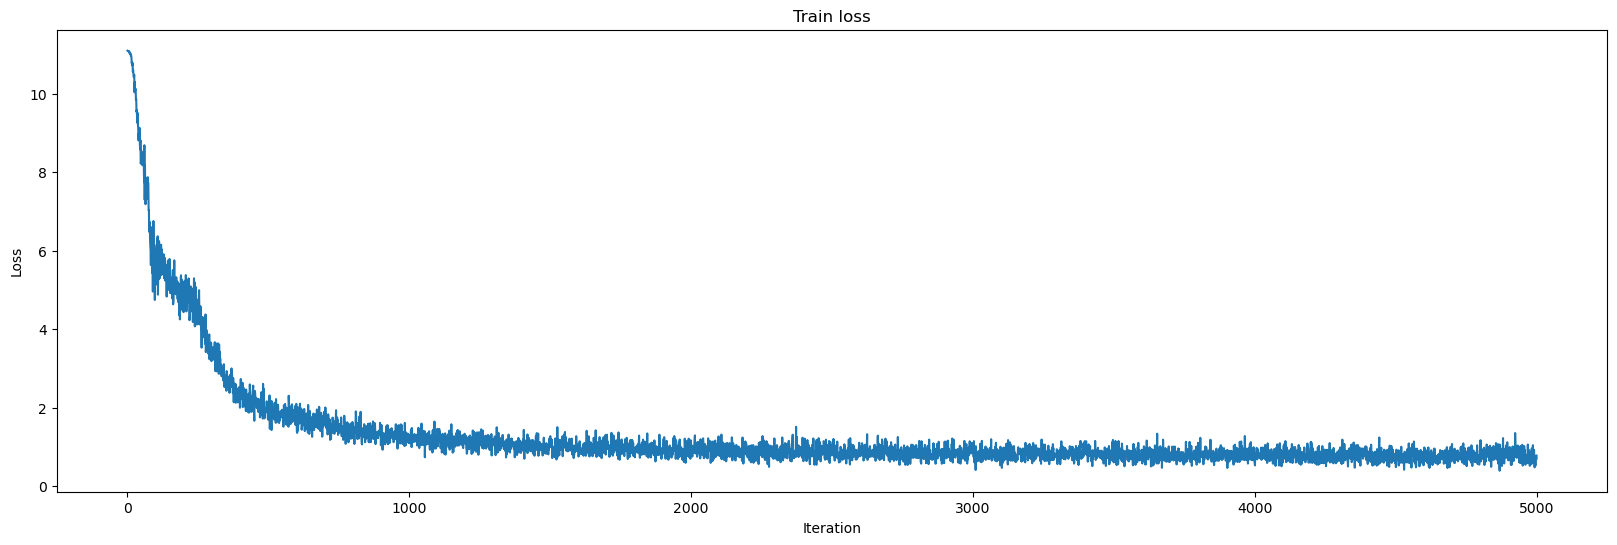

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [20]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print_accuracy(net,test_loader)

Total correctly classified events: 4791/6000
Accuracy: 79.85%


## Legacy Code

In [ ]:
def print_batch_accuracy(net, data, targets, batch_size, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(net, data, targets, batch_size, epoch, counter, iter_counter,
                  loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(net, data, targets, batch_size, train=True)
    print_batch_accuracy(net, test_data, test_targets, batch_size, train=False)
    print("\n")

In [ ]:
def gen_target_2(muon_list):
    target = np.zeros(shape=(len(muon_list)), dtype=np.int16)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

In [ ]:
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

In [ ]:
for data, targets in train_loader:

    print("data shape:", data.shape)
    print("data[2]:", data[2])

    print("\nTarget shape:", targets.shape)
    print("Target[2]:", targets[2])

    spike_in = custom_spikegen(data, num_steps)
    spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))

    print("\nspike_rec shape:", spk_rec.shape)
    
    spk_count = spk_rec.sum(dim=0)
    print("\nspk_count shape:", spk_count.shape)

    print("spk_count[2]:", spk_count[2])

    a = spk_count.view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
    print("\na shape:", a.shape)
    print("a[2]:", a[2])

    _, b = a.max(2)
    print("\nb shape:", b.shape)
    print("b[2]:", b[2])
    
    c = b.view(batch_size, ps.NLAYERS, -1)
    print("\nc shape:", c.shape)
    print("c[2]:", c[2])

    new_target = targets.view(batch_size, -1)
    print("\nlinearised targets shape:", new_target.shape)
    print("linearised targtes[2]:", new_target[2])
    print("")
    
    break

In [ ]:
# Legacy transform: not needed

def pad(muon_hits, max_n_hit):
    padded_array = np.zeros(max_n_hit, dtype=ED.hit_dtype)
    for i, hit in enumerate(muon_hits):
        padded_array[i]['bx']     = hit['bx']
        padded_array[i]['tdc']    = hit['tdc']
        padded_array[i]['label']  = hit['label']
        padded_array[i]['signal'] = hit['signal']

    return padded_array

In [ ]:
def event_to_matrix(event,rec=True):
    tmp_matrix = event['tdc']*(25/30)+event['bx']*25
    tmp_matrix[tmp_matrix <0] = 0
    
    min_value = np.min(tmp_matrix)
    max_value = np.max(tmp_matrix)
    
    tmp_matrix = (tmp_matrix - min_value) / (max_value - min_value)
    
    if rec:
        tmp_matrix[tmp_matrix > 0] = 1/tmp_matrix[tmp_matrix > 0]
        
        min_value = np.min(tmp_matrix)
        max_value = np.max(tmp_matrix)

        tmp_matrix = (tmp_matrix - min_value) / (max_value - min_value)
        
    return tmp_matrix